In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
import seaborn
import pandas as pd

c:\Users\urban\OneDrive\Рабочий стол\timeseries_homework\venv\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [6]:
f = 'sample-3s.wav'

samplerate, data = wavfile.read(f)
print('Sampling Rate:',samplerate)
print('Audio Shape:',np.shape(data))

duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate) 
time = time[:len(time)]

print(f"длительность {duration} \n временная шкала {time} \n размерность времени {len(time)}")

canal1 = data[:,0]
canal2 = data[:,1]

Sampling Rate: 44100
Audio Shape: (140928, 2)
длительность 3.1956462585034013 
 временная шкала [0.00000000e+00 2.26757370e-05 4.53514739e-05 ... 3.19557823e+00
 3.19560091e+00 3.19562358e+00] 
 размерность времени 140928


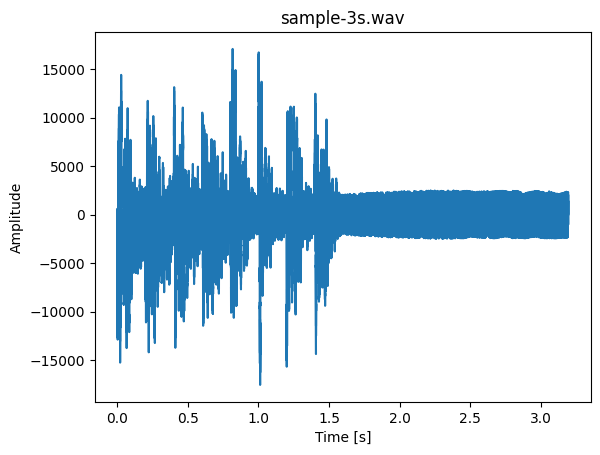

In [4]:
plt.plot(time, canal1)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('sample-3s.wav')
plt.show()

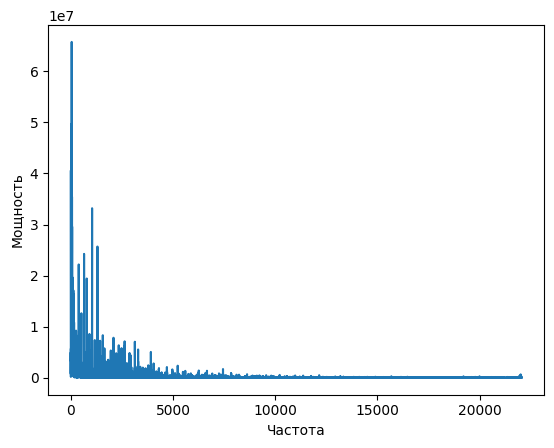

In [5]:
from scipy.fft import  rfft, rfftfreq, irfft

N = int(samplerate * duration)

yf = rfft(canal1)
xf = rfftfreq(N, 1 / samplerate)

plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.show()